In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt

# Load Data

In [2]:
gr = pd.read_csv('official_goodreads_metadata.csv')
am = pd.read_csv('official_amazon_metadata.csv')
am_gr = pd.merge(gr[['asin', 'average_rating']], 
                 am[['asin', 'average', 'rating_count', 'text_reviews_count', 'rank', 'verifiedTrue_count', 'Format',
                     'am_countText_before', 'am_countText_after']], how='inner', on='asin')
am_gr

,asin,average_rating,average,rating_count,text_reviews_count,rank,verifiedTrue_count,Format,am_countText_before,am_countText_after
0,000100039X,4.23,4.64,1453,1453,1810945,1130,NaN,69909,31772
1,0001053655,4.08,4.48,50,50,9799161,43,"Kindle Edition, Paperback, Hardcover, Audi...",4888,2240
2,0001061240,4.62,4.87,45,45,321557,30,Hardcover,3085,1326
3,000161102X,3.86,4.35,17,17,1542999,13,NaN,788,399
4,0001711296,4.29,4.44,107,107,2884610,69,"Library Binding, VHS Tape, Paperback, Hard...",5667,2574
...,...,...,...,...,...,...,...,...,...,...
37228,0312953240,3.80,3.69,13,13,443719,4,"Mass Market Paperback, Hardcover",2599,1216
37229,0312955138,3.38,3.58,12,12,3470182,6,"Kindle Edition, Hardcover",1489,668
37230,0312955154,3.36,3.29,14,14,3412599,4,"Kindle Edition, Paperback",1456,683
37231,0312956878,3.78,3.33,15,15,2606128,9,"Mass Market Paperback, Hardcover",968,450


In [3]:
am_gr = am_gr.rename(columns={'average_rating':'gr_rating', 'average':'am_rating'})
am_gr['rating_diff'] = am_gr['am_rating'] - am_gr['gr_rating']
am_gr.columns

Index(['asin', 'gr_rating', 'am_rating', 'rating_count', 'text_reviews_count',
       'rank', 'verifiedTrue_count', 'Format', 'am_countText_before',
       'am_countText_after', 'rating_diff'],
      dtype='object')

In [4]:
col_names=["asin", "prop_topic_1", "prop_topic_2", "prop_topic_3", "prop_topic_4", 'prop_topic_5', 'prop_topic_6', 
           'prop_topic_7', 'prop_topic_8', 'prop_topic_9', 'prop_topic_10', 'prop_topic_11', 'prop_topic_12', 'prop_topic_13',
           'prop_topic_14', 'prop_topic_15', 'delete']
lda_mallet = pd.read_csv('am_LDA_wmallet_metadata.csv', names=col_names)
lda_mallet = lda_mallet.drop('delete', axis=1)
lda_mallet = pd.merge(lda_mallet, am_gr, on='asin', how='inner')
lda_mallet

,asin,prop_topic_1,prop_topic_2,prop_topic_3,prop_topic_4,prop_topic_5,prop_topic_6,prop_topic_7,prop_topic_8,prop_topic_9,...,gr_rating,am_rating,rating_count,text_reviews_count,rank,verifiedTrue_count,Format,am_countText_before,am_countText_after,rating_diff
0,0001713353,0.019956,0.018601,0.010717,0.021434,0.034368,0.021557,0.014412,0.055802,0.009485,...,4.27,4.83,54,54,1461315,36,"Paperback, Hardcover",2362,1037,0.56
1,0001061240,0.027040,0.012488,0.089381,0.029990,0.009145,0.024877,0.008850,0.013176,0.013176,...,4.62,4.87,45,45,321557,30,Hardcover,3085,1326,0.25
2,0001711296,0.009414,0.011768,0.015709,0.049973,0.029940,0.024302,0.011494,0.018774,0.007718,...,4.29,4.44,107,107,2884610,69,"Library Binding, VHS Tape, Paperback, Hard...",5667,2574,0.15
3,0002007649,0.003491,0.006039,0.009483,0.014768,0.444114,0.009672,0.006511,0.004293,0.009247,...,3.57,3.37,19,19,9799524,3,"Kindle Edition, Paperback, Hardcover",5668,2810,-0.20
4,0001716069,0.015018,0.023002,0.013117,0.044958,0.027849,0.011691,0.012071,0.035168,0.037259,...,3.82,4.61,59,59,3841172,44,"Kindle Edition, Paperback, Hardcover",3081,1457,0.79
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37228,0312943636,0.026640,0.272104,0.013430,0.014691,0.015897,0.049444,0.012224,0.155950,0.023461,...,3.73,4.17,24,24,2583900,9,"Mass Market Paperback, Kindle Edition",5228,2508,0.44
37229,0312953038,0.316304,0.241979,0.010349,0.017876,0.017217,0.024179,0.010725,0.164362,0.015900,...,3.75,4.00,27,27,553268,12,"Mass Market Paperback, Kindle Edition, Pape...",3184,1420,0.25
37230,0312955154,0.040023,0.035830,0.016962,0.040023,0.022680,0.014294,0.014103,0.025538,0.042691,...,3.36,3.29,14,14,3412599,4,"Kindle Edition, Paperback",1456,683,-0.07
37231,0312956878,0.022327,0.073023,0.083793,0.029419,0.041502,0.116890,0.020489,0.024691,0.096927,...,3.78,3.33,15,15,2606128,9,"Mass Market Paperback, Hardcover",968,450,-0.45


In [5]:
lda_mallet.isnull().sum()

asin                    0
prop_topic_1            0
prop_topic_2            0
prop_topic_3            0
prop_topic_4            0
prop_topic_5            0
prop_topic_6            0
prop_topic_7            0
prop_topic_8            0
prop_topic_9            0
prop_topic_10           0
prop_topic_11           0
prop_topic_12           0
prop_topic_13           0
prop_topic_14           0
prop_topic_15           0
gr_rating               0
am_rating               0
rating_count            0
text_reviews_count      0
rank                    0
verifiedTrue_count      0
Format                 49
am_countText_before     0
am_countText_after      0
rating_diff             0
dtype: int64

# Random Forest

### RF w/o Format

##### Predicting gr_rating

In [6]:
y = np.array(lda_mallet['gr_rating'])
x = lda_mallet.drop('asin', axis=1).drop('gr_rating', axis=1).drop('Format', axis=1).drop('rating_diff', axis=1)
features = list(x.columns)
x = np.array(x)

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state = 0)

# Train the model on training data
rf = RandomForestRegressor(n_estimators = 1155, min_samples_split = 35, min_samples_leaf = 3, max_leaf_nodes = 7000,
                           max_features = 'auto', max_depth = 30, bootstrap = True, n_jobs=4)
rf.fit(x_train, y_train)

# Use the forest's predict method on the train data
predictions = rf.predict(x_train)
print('TRAIN DATA:')
print('Mean Absolute Error:', mean_absolute_error(y_train, predictions))
print('Mean Squared Error:', mean_squared_error(y_train, predictions))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_train, predictions)))
r2 = rf.score(x_train, y_train)
n = x_train.shape[0]
p = x_train.shape[1]
adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)
print('R2 Adjusted Score:', adjusted_r2)

print('----------------------------------')

# Use the forest's predict method on the test data
predictions = rf.predict(x_test)
print('TEST DATA:')
print('Mean Absolute Error:', mean_absolute_error(y_test, predictions))
print('Mean Squared Error:', mean_squared_error(y_test, predictions))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, predictions)))
r2 = rf.score(x_test, y_test)
n = x_test.shape[0]
p = x_test.shape[1]
adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)
print('R2 Adjusted Score:', adjusted_r2)

TRAIN DATA:
Mean Absolute Error: 0.12248934197845089
Mean Squared Error: 0.026502747115705824
Root Mean Squared Error: 0.16279664344115274
R2 Adjusted Score: 0.7158104198613875
----------------------------------
TEST DATA:
Mean Absolute Error: 0.16056489736113097
Mean Squared Error: 0.045230099646270436
Root Mean Squared Error: 0.21267369288717972
R2 Adjusted Score: 0.5222340432479968


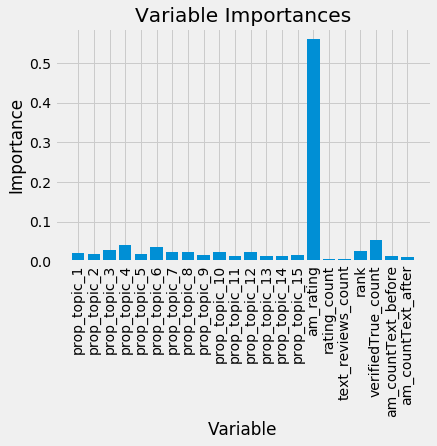

In [7]:
importances = list(rf.feature_importances_)

# Set the style
plt.style.use('fivethirtyeight')

# list of x locations for plotting
x_values = list(range(len(importances)))

# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')

# Tick labels for x axis
plt.xticks(x_values, features, rotation='vertical')

# Axis labels and title
plt.ylabel('Importance')
plt.xlabel('Variable')
plt.title('Variable Importances')
plt.show()

##### Predicting rating_diff

In [8]:
y = np.array(lda_mallet['rating_diff'])
x = lda_mallet.drop('asin', axis=1).drop('gr_rating', axis=1).drop('Format', axis=1).drop('rating_diff', axis=1)
x = np.array(x)

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state = 0)

# Train the model on training data
rf = RandomForestRegressor(n_estimators = 1155, min_samples_split = 35, min_samples_leaf = 3, max_leaf_nodes = 7000,
                           max_features = 'auto', max_depth = 30, bootstrap = True, n_jobs=4)
rf.fit(x_train, y_train)

# Use the forest's predict method on the train data
predictions = rf.predict(x_train)
print('TRAIN DATA:')
print('Mean Absolute Error:', mean_absolute_error(y_train, predictions))
print('Mean Squared Error:', mean_squared_error(y_train, predictions))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_train, predictions)))
r2 = rf.score(x_train, y_train)
n = x_train.shape[0]
p = x_train.shape[1]
adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)
print('R2 Adjusted Score:', adjusted_r2)

print('----------------------------------')

# Use the forest's predict method on the test data
predictions = rf.predict(x_test)
print('TEST DATA:')
print('Mean Absolute Error:', mean_absolute_error(y_test, predictions))
print('Mean Squared Error:', mean_squared_error(y_test, predictions))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, predictions)))
r2 = rf.score(x_test, y_test)
n = x_test.shape[0]
p = x_test.shape[1]
adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)
print('R2 Adjusted Score:', adjusted_r2)

TRAIN DATA:
Mean Absolute Error: 0.1225621467664387
Mean Squared Error: 0.02670931760796713
Root Mean Squared Error: 0.1634298553140372
R2 Adjusted Score: 0.7629769387734487
----------------------------------
TEST DATA:
Mean Absolute Error: 0.16122210736167475
Mean Squared Error: 0.04586954442231879
Root Mean Squared Error: 0.2141717638306198
R2 Adjusted Score: 0.5870554093598728


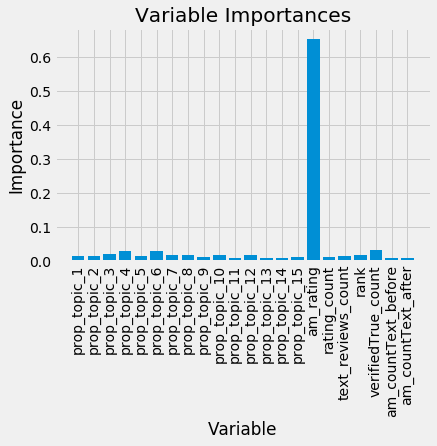

In [9]:
importances = list(rf.feature_importances_)

# Set the style
plt.style.use('fivethirtyeight')

# list of x locations for plotting
x_values = list(range(len(importances)))

# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')

# Tick labels for x axis
plt.xticks(x_values, features, rotation='vertical')

# Axis labels and title
plt.ylabel('Importance')
plt.xlabel('Variable')
plt.title('Variable Importances')
plt.show()

##### Predicting rating_diff w/ just am_rating

In [10]:
y = np.array(lda_mallet['rating_diff'])
x = lda_mallet[['am_rating']]
x = np.array(x)

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state = 0)

# Train the model on training data
rf = RandomForestRegressor(n_estimators = 1155, min_samples_split = 35, min_samples_leaf = 3, max_leaf_nodes = 7000,
                           max_features = 'auto', max_depth = 30, bootstrap = True, n_jobs=4)
rf.fit(x_train, y_train)

# Use the forest's predict method on the train data
predictions = rf.predict(x_train)
print('TRAIN DATA:')
print('Mean Absolute Error:', mean_absolute_error(y_train, predictions))
print('Mean Squared Error:', mean_squared_error(y_train, predictions))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_train, predictions)))
r2 = rf.score(x_train, y_train)
n = x_train.shape[0]
p = x_train.shape[1]
adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)
print('R2 Adjusted Score:', adjusted_r2)

print('----------------------------------')

# Use the forest's predict method on the test data
predictions = rf.predict(x_test)
print('TEST DATA:')
print('Mean Absolute Error:', mean_absolute_error(y_test, predictions))
print('Mean Squared Error:', mean_squared_error(y_test, predictions))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, predictions)))
r2 = rf.score(x_test, y_test)
n = x_test.shape[0]
p = x_test.shape[1]
adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)
print('R2 Adjusted Score:', adjusted_r2)

TRAIN DATA:
Mean Absolute Error: 0.1823640260956363
Mean Squared Error: 0.0564969025225461
Root Mean Squared Error: 0.23769077079799733
R2 Adjusted Score: 0.4990138788043489
----------------------------------
TEST DATA:
Mean Absolute Error: 0.1837094913016536
Mean Squared Error: 0.05755502023256944
Root Mean Squared Error: 0.23990627384995467
R2 Adjusted Score: 0.4830250128785768


Verdict: Predicting GR ratings slightly better than predicting differences but not much. Using just am_rank is not good enough

### RF w/ Format

In [11]:
am_gr['Format'] = am_gr['Format'].str.replace(' ','')
Format = pd.get_dummies(am_gr['Format'].str.get_dummies(sep=','))
Format.astype('int8')
Format = pd.concat([Format, am_gr['asin']], axis=1)
lda_format = pd.merge(lda_mallet, Format, how='left', on='asin')
lda_format.isnull().sum()

asin              0
prop_topic_1      0
prop_topic_2      0
prop_topic_3      0
prop_topic_4      0
                 ..
Unbound           0
UnknownBinding    0
VHSTape           0
Vinyl             0
VinylBound        0
Length: 96, dtype: int64

In [12]:
y = np.array(lda_format['rating_diff'])
x = lda_format.drop('asin', axis=1).drop('gr_rating', axis=1).drop('Format', axis=1).drop('rating_diff', axis=1)
features = list(x.columns)
x = np.array(x)

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state = 0)

# Train the model on training data
rf = RandomForestRegressor(n_estimators = 1155, min_samples_split = 35, min_samples_leaf = 3, max_leaf_nodes = 7000,
                           max_features = 'auto', max_depth = 30, bootstrap = True, n_jobs=4)
rf.fit(x_train, y_train)

# Use the forest's predict method on the train data
predictions = rf.predict(x_train)
print('TRAIN DATA:')
print('Mean Absolute Error:', mean_absolute_error(y_train, predictions))
print('Mean Squared Error:', mean_squared_error(y_train, predictions))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_train, predictions)))
r2 = rf.score(x_train, y_train)
n = x_train.shape[0]
p = x_train.shape[1]
adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)
print('R2 Adjusted Score:', adjusted_r2)

print('----------------------------------')

# Use the forest's predict method on the test data
predictions = rf.predict(x_test)
print('TEST DATA:')
print('Mean Absolute Error:', mean_absolute_error(y_test, predictions))
print('Mean Squared Error:', mean_squared_error(y_test, predictions))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, predictions)))
r2 = rf.score(x_test, y_test)
n = x_test.shape[0]
p = x_test.shape[1]
adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)
print('R2 Adjusted Score:', adjusted_r2)

TRAIN DATA:
Mean Absolute Error: 0.12196762398159831
Mean Squared Error: 0.0264656584493393
Root Mean Squared Error: 0.1626826925316252
R2 Adjusted Score: 0.7645484945277821
----------------------------------
TEST DATA:
Mean Absolute Error: 0.1603625702921871
Mean Squared Error: 0.04549383818757848
Root Mean Squared Error: 0.2132928460768867
R2 Adjusted Score: 0.5873269131648206


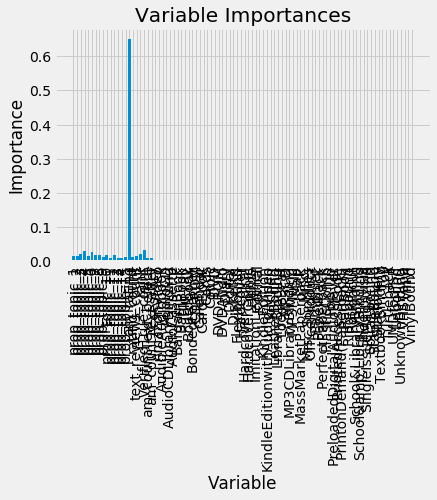

In [13]:
importances = list(rf.feature_importances_)

# Set the style
plt.style.use('fivethirtyeight')

# list of x locations for plotting
x_values = list(range(len(importances)))

# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')

# Tick labels for x axis
plt.xticks(x_values, features, rotation='vertical')

# Axis labels and title
plt.ylabel('Importance')
plt.xlabel('Variable')
plt.title('Variable Importances')
plt.show()

Verdict: Not much improvements!

# Xgboost

### Xgboost w/o Format

In [14]:
y = np.array(lda_mallet['rating_diff'])
x = lda_mallet.drop('asin', axis=1).drop(['rating_diff', 'Format', 'gr_rating'], axis=1)
features = list(x.columns)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.25, random_state=0)

# fit model no training data
model = xgb.XGBRegressor(eta=0.1, min_child_weight=10, tree_method='approx')
model.fit(x_train, y_train)

# make predictions for train data
y_pred = model.predict(x_train)
print('TRAIN DATA:')
print('Mean Absolute Error:', mean_absolute_error(y_train, y_pred))
print('Mean Squared Error:', mean_squared_error(y_train, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_train, y_pred)))
r2 = model.score(x_train, y_train)
n = x_train.shape[0]
p = x_train.shape[1]
adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)
print('R2 Adjusted Score:', adjusted_r2)

print('----------------------------------')

# make predictions for test data
y_pred = model.predict(x_test)
print('TEST DATA:')
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
r2 = model.score(x_test, y_test)
n = x_test.shape[0]
p = x_test.shape[1]
adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)
print('R2 Adjusted Score:', adjusted_r2)

TRAIN DATA:
Mean Absolute Error: 0.14130565814222446
Mean Squared Error: 0.0342683154072209
Root Mean Squared Error: 0.18511703165084759
R2 Adjusted Score: 0.6958970970312749
----------------------------------
TEST DATA:
Mean Absolute Error: 0.15987268498382093
Mean Squared Error: 0.045471708728497026
Root Mean Squared Error: 0.21324096400198772
R2 Adjusted Score: 0.5906369600335551


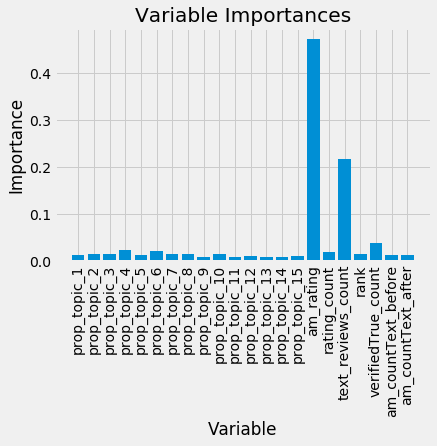

In [15]:
importances = list(model.feature_importances_)

# Set the style
plt.style.use('fivethirtyeight')

# list of x locations for plotting
x_values = list(range(len(importances)))

# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')

# Tick labels for x axis
plt.xticks(x_values, features, rotation='vertical')

# Axis labels and title
plt.ylabel('Importance')
plt.xlabel('Variable')
plt.title('Variable Importances')
plt.show()

In [16]:
y = np.array(lda_mallet['rating_diff'])
x = lda_mallet[['am_rating', 'text_reviews_count']]
features = list(x.columns)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.25, random_state=0)

# fit model no training data
model = xgb.XGBRegressor(eta=0.1, min_child_weight=10, tree_method='approx')
model.fit(x_train, y_train)

# make predictions for train data
y_pred = model.predict(x_train)
print('TRAIN DATA:')
print('Mean Absolute Error:', mean_absolute_error(y_train, y_pred))
print('Mean Squared Error:', mean_squared_error(y_train, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_train, y_pred)))
r2 = model.score(x_train, y_train)
n = x_train.shape[0]
p = x_train.shape[1]
adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)
print('R2 Adjusted Score:', adjusted_r2)

print('----------------------------------')

# make predictions for test data
y_pred = model.predict(x_test)
print('TEST DATA:')
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
r2 = model.score(x_test, y_test)
n = x_test.shape[0]
p = x_test.shape[1]
adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)
print('R2 Adjusted Score:', adjusted_r2)

TRAIN DATA:
Mean Absolute Error: 0.17447065215114363
Mean Squared Error: 0.052628595822438014
Root Mean Squared Error: 0.22940923220837914
R2 Adjusted Score: 0.5332993629392379
----------------------------------
TEST DATA:
Mean Absolute Error: 0.18017279814016754
Mean Squared Error: 0.05659106104846325
Root Mean Squared Error: 0.2378887577176846
R2 Adjusted Score: 0.49162893637749283


Verdict: Not as good

In [17]:
y = np.array(lda_mallet['gr_rating'])
x = lda_mallet.drop('asin', axis=1).drop(['rating_diff', 'Format', 'gr_rating'], axis=1)
features = list(x.columns)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.25, random_state=0)

# fit model no training data
model = xgb.XGBRegressor(eta=0.1, min_child_weight=10, tree_method='approx')
model.fit(x_train, y_train)

# make predictions for train data
y_pred = model.predict(x_train)
print('TRAIN DATA:')
print('Mean Absolute Error:', mean_absolute_error(y_train, y_pred))
print('Mean Squared Error:', mean_squared_error(y_train, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_train, y_pred)))
r2 = model.score(x_train, y_train)
n = x_train.shape[0]
p = x_train.shape[1]
adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)
print('R2 Adjusted Score:', adjusted_r2)

print('----------------------------------')

# make predictions for test data
y_pred = model.predict(x_test)
print('TEST DATA:')
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
r2 = model.score(x_test, y_test)
n = x_test.shape[0]
p = x_test.shape[1]
adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)
print('R2 Adjusted Score:', adjusted_r2)

TRAIN DATA:
Mean Absolute Error: 0.14368030895870576
Mean Squared Error: 0.03542338162417629
Root Mean Squared Error: 0.18821100293069024
R2 Adjusted Score: 0.6201542463913594
----------------------------------
TEST DATA:
Mean Absolute Error: 0.15797320165725334
Mean Squared Error: 0.04370160645151526
Root Mean Squared Error: 0.2090492919182346
R2 Adjusted Score: 0.5383795308611632


### Xgboost w/ Format

In [18]:
y = np.array(lda_format['rating_diff'])
x = lda_format.drop('asin', axis=1).drop(['rating_diff', 'Format', 'gr_rating'], axis=1)
features = list(x.columns)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.25, random_state=0)

# fit model no training data
model = xgb.XGBRegressor(eta=0.1, min_child_weight=10, tree_method='approx')
model.fit(x_train, y_train)

# make predictions for train data
y_pred = model.predict(x_train)
print('TRAIN DATA:')
print('Mean Absolute Error:', mean_absolute_error(y_train, y_pred))
print('Mean Squared Error:', mean_squared_error(y_train, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_train, y_pred)))
r2 = model.score(x_train, y_train)
n = x_train.shape[0]
p = x_train.shape[1]
adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)
print('R2 Adjusted Score:', adjusted_r2)

print('----------------------------------')

# make predictions for test data
y_pred = model.predict(x_test)
print('TEST DATA:')
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
r2 = model.score(x_test, y_test)
n = x_test.shape[0]
p = x_test.shape[1]
adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)
print('R2 Adjusted Score:', adjusted_r2)

TRAIN DATA:
Mean Absolute Error: 0.13992834200662352
Mean Squared Error: 0.033622481753675666
Root Mean Squared Error: 0.18336434155439182
R2 Adjusted Score: 0.7008778768240795
----------------------------------
TEST DATA:
Mean Absolute Error: 0.158220490570137
Mean Squared Error: 0.04465358004145613
Root Mean Squared Error: 0.21131393716803473
R2 Adjusted Score: 0.5949488667460726


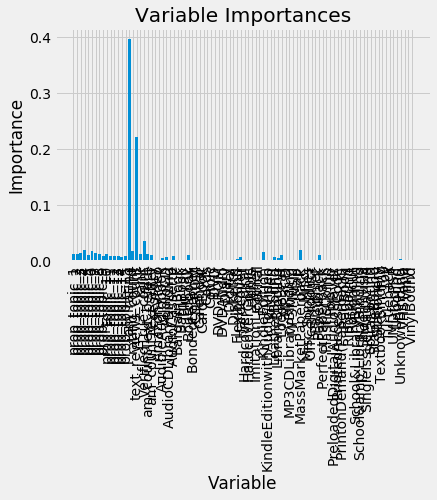

In [19]:
importances = list(model.feature_importances_)

# Set the style
plt.style.use('fivethirtyeight')

# list of x locations for plotting
x_values = list(range(len(importances)))

# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')

# Tick labels for x axis
plt.xticks(x_values, features, rotation='vertical')

# Axis labels and title
plt.ylabel('Importance')
plt.xlabel('Variable')
plt.title('Variable Importances')
plt.show()

Verdict: Not much better!

# Neural Network

### NN w/o Format

In [20]:
y = np.array(lda_mallet['rating_diff'])
x = lda_mallet.drop('asin', axis=1).drop('rating_diff', axis=1).drop('Format', axis=1).drop('gr_rating', axis=1)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.25, random_state=0)
# normalize features
scaler = StandardScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
# fit model no training data
model = MLPRegressor(hidden_layer_sizes=(14,), solver='lbfgs', alpha=0.002, max_iter=500)
model.fit(x_train, y_train)

# make predictions for train data
y_pred = model.predict(x_train)
print('TRAIN DATA:')
print('Mean Absolute Error:', mean_absolute_error(y_train, y_pred))
print('Mean Squared Error:', mean_squared_error(y_train, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_train, y_pred)))
r2 = model.score(x_train, y_train)
n = x_train.shape[0]
p = x_train.shape[1]
adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)
print('R2 Adjusted Score:', adjusted_r2)

print('----------------------------------')

# make predictions for test data
y_pred = model.predict(x_test)
print('TEST DATA:')
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
r2 = model.score(x_test, y_test)
n = x_test.shape[0]
p = x_test.shape[1]
adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)
print('R2 Adjusted Score:', adjusted_r2)

TRAIN DATA:
Mean Absolute Error: 0.16251821817599207
Mean Squared Error: 0.045134546252147204
Root Mean Squared Error: 0.21244892622027348
R2 Adjusted Score: 0.599468302531091
----------------------------------
TEST DATA:
Mean Absolute Error: 0.1619711593465088
Mean Squared Error: 0.04561129244931574
Root Mean Squared Error: 0.21356800427338302
R2 Adjusted Score: 0.5893803453629837


C:\Users\Tu Lam\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


### NN w/ Format

In [21]:
y = np.array(lda_format['rating_diff'])
x = lda_format.drop('asin', axis=1).drop('rating_diff', axis=1).drop('Format', axis=1).drop('gr_rating', axis=1)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.25, random_state=0)
# normalize features
scaler = StandardScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
# fit model no training data
model = MLPRegressor(hidden_layer_sizes=(14,), solver='lbfgs', alpha=0.002, max_iter=500)
model.fit(x_train, y_train)

# make predictions for train data
y_pred = model.predict(x_train)
print('TRAIN DATA:')
print('Mean Absolute Error:', mean_absolute_error(y_train, y_pred))
print('Mean Squared Error:', mean_squared_error(y_train, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_train, y_pred)))
r2 = model.score(x_train, y_train)
n = x_train.shape[0]
p = x_train.shape[1]
adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)
print('R2 Adjusted Score:', adjusted_r2)

print('----------------------------------')

# make predictions for test data
y_pred = model.predict(x_test)
print('TEST DATA:')
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
r2 = model.score(x_test, y_test)
n = x_test.shape[0]
p = x_test.shape[1]
adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)
print('R2 Adjusted Score:', adjusted_r2)

TRAIN DATA:
Mean Absolute Error: 0.15992925637028318
Mean Squared Error: 0.0439655099654023
Root Mean Squared Error: 0.2096795411226434
R2 Adjusted Score: 0.6088612142402149
----------------------------------
TEST DATA:
Mean Absolute Error: 0.16361903021303292
Mean Squared Error: 0.04840906264775074
Root Mean Squared Error: 0.22002059596262968
R2 Adjusted Score: 0.5608830094467743


C:\Users\Tu Lam\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


# Best Models

In [22]:
"""
RF - ALL W/O FORMAT
    TRAIN DATA:
    Mean Absolute Error: 0.12256290891675341
    Mean Squared Error: 0.026712287851368713
    Root Mean Squared Error: 0.1634389422731581
    R2 Adjusted Score: 0.7629505803245372
    ----------------------------------
    TEST DATA:
    Mean Absolute Error: 0.16112000791413247
    Mean Squared Error: 0.045815474050919465
    Root Mean Squared Error: 0.21404549528294087
    R2 Adjusted Score: 0.5875421826135523

RF - AM_RATING
    TRAIN DATA:
    Mean Absolute Error: 0.18236911932378577
    Mean Squared Error: 0.05649580972636557
    Root Mean Squared Error: 0.23768847200982543
    R2 Adjusted Score: 0.4990235691713478
    ----------------------------------
    TEST DATA:
    Mean Absolute Error: 0.18371719594558142
    Mean Squared Error: 0.0575524335137913
    Root Mean Squared Error: 0.2399008826865614
    R2 Adjusted Score: 0.48304824749654085

XGB - ALL W/O FORMAT
    TRAIN DATA:
    Mean Absolute Error: 0.14130565814222446
    Mean Squared Error: 0.0342683154072209
    Root Mean Squared Error: 0.18511703165084759
    R2 Adjusted Score: 0.6958970970312749
    ----------------------------------
    TEST DATA:
    Mean Absolute Error: 0.15987268498382093
    Mean Squared Error: 0.045471708728497026
    Root Mean Squared Error: 0.21324096400198772
    R2 Adjusted Score: 0.5906369600335551

XGB - PREDICT GR_RATING
    TRAIN DATA:
    Mean Absolute Error: 0.14368030895870576
    Mean Squared Error: 0.03542338162417629
    Root Mean Squared Error: 0.18821100293069024
    R2 Adjusted Score: 0.6201542463913594
    ----------------------------------
    TEST DATA:
    Mean Absolute Error: 0.15797320165725334
    Mean Squared Error: 0.04370160645151526
    Root Mean Squared Error: 0.2090492919182346
    R2 Adjusted Score: 0.5383795308611632

NN - ALL W/O FORMAT
    TRAIN DATA:
    Mean Absolute Error: 0.16180631713448332
    Mean Squared Error: 0.04484993862334463
    Root Mean Squared Error: 0.21177804093754535
    R2 Adjusted Score: 0.6019939593980074
    ----------------------------------
    TEST DATA:
    Mean Absolute Error: 0.16211333883344414
    Mean Squared Error: 0.04566488041370557
    Root Mean Squared Error: 0.21369342622950657
    R2 Adjusted Score: 0.5888979150206535
""";

Conclusion: Even better than XGB for model that predicts from both GR & AM!!!

# Ensemble

### Weighted Averages / Voting 

##### Voting w/o weights

In [23]:
y = np.array(lda_mallet['rating_diff'])
x = lda_mallet.drop('asin', axis=1).drop('rating_diff', axis=1).drop('Format', axis=1).drop('gr_rating', axis=1)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.25, random_state=0)

model1 = RandomForestRegressor(n_estimators = 1155, min_samples_split = 35, min_samples_leaf = 3, max_leaf_nodes = 7000, 
                               max_features = 'auto', max_depth = 30, bootstrap = True, n_jobs=4)
model2 = xgb.XGBRegressor(eta=0.1, min_child_weight=10, tree_method='approx')
model3 = MLPRegressor(hidden_layer_sizes=(14,), solver='lbfgs', alpha=0.002, max_iter=500)

model1.fit(x_train, y_train)
model2.fit(x_train, y_train)

scaler = StandardScaler()
scaler.fit(x_train)
x_train_nn = scaler.transform(x_train)
x_test_nn = scaler.transform(x_test)

model3.fit(x_train_nn, y_train)

C:\Users\Tu Lam\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLPRegressor(alpha=0.002, hidden_layer_sizes=(14,), max_iter=500,
             solver='lbfgs')

In [24]:
# make predictions for train data
model1_pred = np.array(model1.predict(x_train))
model2_pred = np.array(model2.predict(x_train))
model3_pred = np.array(model3.predict(x_train_nn))
y_pred = ((33*model1_pred) + (34*model2_pred) + (33*model3_pred))/100
print('TRAIN DATA:')
print('Mean Absolute Error:', mean_absolute_error(y_train, y_pred))
print('Mean Squared Error:', mean_squared_error(y_train, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_train, y_pred)))
r2 = r2_score(y_train, y_pred)
n = x_train.shape[0]
p = x_train.shape[1]
adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)
print('R2 Adjusted Score:', adjusted_r2)

print('----------------------------------')

# make predictions for test data
model1_pred = np.array(model1.predict(x_test))
model2_pred = np.array(model2.predict(x_test))
model3_pred = np.array(model3.predict(x_test_nn))
y_pred = ((33*model1_pred) + (34*model2_pred) + (33*model3_pred))/100
print('TEST DATA:')
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
r2 = r2_score(y_test, y_pred)
n = x_test.shape[0]
p = x_test.shape[1]
adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)
print('R2 Adjusted Score:', adjusted_r2)

TRAIN DATA:
Mean Absolute Error: 0.14009086594986644
Mean Squared Error: 0.0339751497429421
Root Mean Squared Error: 0.1843234921081469
R2 Adjusted Score: 0.698498699371469
----------------------------------
TEST DATA:
Mean Absolute Error: 0.1589270674190083
Mean Squared Error: 0.04450748659114024
Root Mean Squared Error: 0.21096797527383213
R2 Adjusted Score: 0.599317454265872


##### Voting w/ weights

In [25]:
# make predictions for train data
model1_pred = np.array(model1.predict(x_train))
model2_pred = np.array(model2.predict(x_train))
model3_pred = np.array(model3.predict(x_train_nn))
y_pred = ((25*model1_pred) + (38*model2_pred) + (37*model3_pred))/100
print('TRAIN DATA:')
print('Mean Absolute Error:', mean_absolute_error(y_train, y_pred))
print('Mean Squared Error:', mean_squared_error(y_train, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_train, y_pred)))
r2 = r2_score(y_train, y_pred)
n = x_train.shape[0]
p = x_train.shape[1]
adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)
print('R2 Adjusted Score:', adjusted_r2)

print('----------------------------------')

# make predictions for test data
model1_pred = np.array(model1.predict(x_test))
model2_pred = np.array(model2.predict(x_test))
model3_pred = np.array(model3.predict(x_test_nn))
y_pred = ((25*model1_pred) + (38*model2_pred) + (37*model3_pred))/100
print('TEST DATA:')
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
r2 = r2_score(y_test, y_pred)
n = x_test.shape[0]
p = x_test.shape[1]
adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)
print('R2 Adjusted Score:', adjusted_r2)

TRAIN DATA:
Mean Absolute Error: 0.14240654348038093
Mean Squared Error: 0.03501302136084423
Root Mean Squared Error: 0.18711766715316924
R2 Adjusted Score: 0.6892884487897792
----------------------------------
TEST DATA:
Mean Absolute Error: 0.1589146064790178
Mean Squared Error: 0.044476097987635965
Root Mean Squared Error: 0.21089357028519376
R2 Adjusted Score: 0.599600032917744


In [ ]:
"""
NOTE: RANKED BEST TO WORST TEST PERFORMANCE:

ENSEMBLE - 25-38-37
    TRAIN DATA:
    Mean Absolute Error: 0.14240654348038093
    Mean Squared Error: 0.03501302136084423
    Root Mean Squared Error: 0.18711766715316924
    R2 Adjusted Score: 0.6892884487897792
    ----------------------------------
    TEST DATA:
    Mean Absolute Error: 0.1589146064790178
    Mean Squared Error: 0.044476097987635965
    Root Mean Squared Error: 0.21089357028519376
    R2 Adjusted Score: 0.599600032917744

ENSEMBLE - 33-34-33
TRAIN DATA:
    Mean Absolute Error: 0.14009086594986644
    Mean Squared Error: 0.0339751497429421
    Root Mean Squared Error: 0.1843234921081469
    R2 Adjusted Score: 0.698498699371469
    ----------------------------------
    TEST DATA:
    Mean Absolute Error: 0.1589270674190083
    Mean Squared Error: 0.04450748659114024
    Root Mean Squared Error: 0.21096797527383213
    R2 Adjusted Score: 0.599317454265872

XGB - ALL W/O FORMAT
    TRAIN DATA:
    Mean Absolute Error: 0.14130565814222446
    Mean Squared Error: 0.0342683154072209
    Root Mean Squared Error: 0.18511703165084759
    R2 Adjusted Score: 0.6958970970312749
    ----------------------------------
    TEST DATA:
    Mean Absolute Error: 0.15987268498382093
    Mean Squared Error: 0.045471708728497026
    Root Mean Squared Error: 0.21324096400198772
    R2 Adjusted Score: 0.5906369600335551

RF - ALL W/O FORMAT
    TRAIN DATA:
    Mean Absolute Error: 0.12256290891675341
    Mean Squared Error: 0.026712287851368713
    Root Mean Squared Error: 0.1634389422731581
    R2 Adjusted Score: 0.7629505803245372
    ----------------------------------
    TEST DATA:
    Mean Absolute Error: 0.16112000791413247
    Mean Squared Error: 0.045815474050919465
    Root Mean Squared Error: 0.21404549528294087
    R2 Adjusted Score: 0.5875421826135523

NN - ALL W/O FORMAT
    TRAIN DATA:
    Mean Absolute Error: 0.16180631713448332
    Mean Squared Error: 0.04484993862334463
    Root Mean Squared Error: 0.21177804093754535
    R2 Adjusted Score: 0.6019939593980074
    ----------------------------------
    TEST DATA:
    Mean Absolute Error: 0.16211333883344414
    Mean Squared Error: 0.04566488041370557
    Root Mean Squared Error: 0.21369342622950657
    R2 Adjusted Score: 0.5888979150206535

RF - AM_RATING
    TRAIN DATA:
    Mean Absolute Error: 0.18236911932378577
    Mean Squared Error: 0.05649580972636557
    Root Mean Squared Error: 0.23768847200982543
    R2 Adjusted Score: 0.4990235691713478
    ----------------------------------
    TEST DATA:
    Mean Absolute Error: 0.18371719594558142
    Mean Squared Error: 0.0575524335137913
    Root Mean Squared Error: 0.2399008826865614
    R2 Adjusted Score: 0.48304824749654085
""";